In [32]:
%reload_ext autoreload
import os
os.chdir("/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/PointCloudPosePrediction")
import importlib
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import open3d as o3d
from scipy.io import loadmat
from scipy.spatial.transform import Rotation as R
import tqdm
from typing import Any, Callable, Optional, Tuple
import yaml
import cv2
import matplotlib.pyplot as plt
import core.pointnet as pnet
import core.deep_pose_estimator as dpe
importlib.reload(dpe)
importlib.reload(pnet)
import core.deep_pose_estimator as dpe
import utils.dataloader
import utils.utils
import utils.vision
importlib.reload(utils.utils)
importlib.reload(utils.vision)
importlib.reload(utils.dataloader)

<module 'utils.dataloader' from '/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/PointCloudPosePrediction/utils/dataloader.py'>

In [2]:
# load params for current model run; choose model run below after creating yaml file for it
with open("./models/run_1.yaml") as f:
    params = yaml.safe_load(f)

In [34]:
# create data loader for Eden data - outputs pairs of point clouds and relative poses
dataset=utils.dataloader.EdenDataset("/Users/mustafa/Documents/grad school/spring 2024/ECE285 - Visual Learning/eden/sample",
                                            train=True,
                                            keypt_method=params['keypoint_detection']['detection_method'],
                                            pcd_num_pts=params['keypoint_detection']['pcd_num_pts']
                                            )
edenLoader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=1)

In [35]:
# create a batch for dev/testing purposes
batch = next(iter(edenLoader))

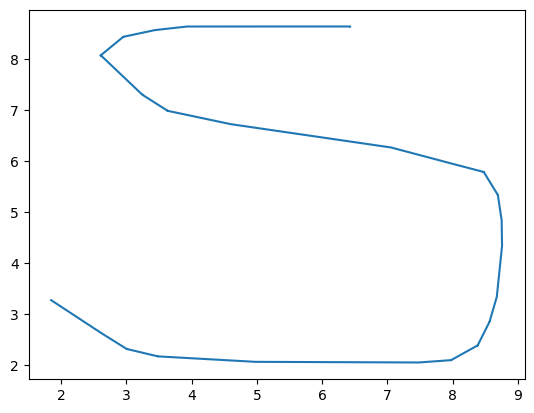

In [36]:
# visualize the trajectory of a sequence
positions = torch.zeros((500, 3))
for j in range(100):
    positions[j] = dataset[j]['pose'][:3,3]

plt.plot(positions[:100,0],positions[:100,1])
plt.show()

### PointNet - extract feature vector, reduce dimensions, visualize results

In [37]:
# nx128 feature vector from combined global and local features from segmentation branch
batch_feat_vec128 = dpe.DeepPoseEstimator()(batch['pcd1'].permute(0,2,1), batch['pcd2'].permute(0,2,1))
batch_feat_vec128 = batch_feat_vec128.permute(0,2,1)

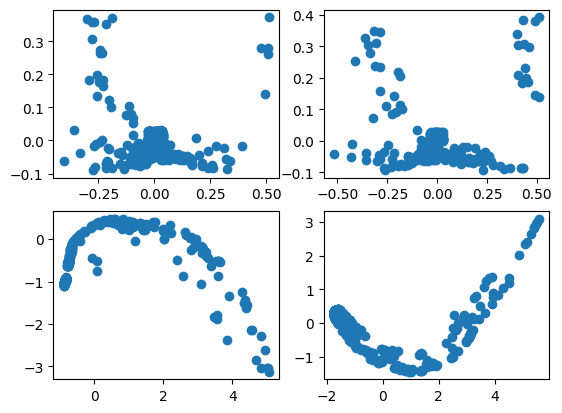

In [46]:
# visualize 2-D (PCA) feature vectors across successive images

# first plot the original input downsampled pointcloud
plt.subplot(2,2,1)
plt.scatter(batch[0][:,0],batch[0][:,1])
plt.subplot(2,2,2)
plt.scatter(batch[1][:,0],batch[1][:,1])

# now visualize the low-dim data - ignore the orientation; only the relative structure matters
plt.subplot(2,2,3)
plt.scatter(batch_low_dim_feat_vec[0][:,0],batch_low_dim_feat_vec[0][:,1])
plt.subplot(2,2,4)
plt.scatter(batch_low_dim_feat_vec[1][:,0],batch_low_dim_feat_vec[1][:,1])
plt.show()